# Load cricut image data txt file

In [3]:
import json
from tqdm import tqdm

def load_txt_to_dict(file_path):
    data_dicts = []
    total_line = 0
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    lines = lines[:-1]

    data_dicts = []
    with tqdm(total=len(lines), desc='Loading', unit='line') as pbar:
        for i, line in enumerate(lines, start=1):
            try:
                data = json.loads(line.strip())
                extracted_data = {
                    "name": data.get("name"),
                    "id": data.get("id"),
                    "previewUrl": data.get("previewUrl"),
                    "filters": [filter_item.get("name") for filter_item in data.get("filters", [])] if "filters" in data and data.get("filters", []) is not None else []
                }
                data_dicts.append(extracted_data)
            except json.JSONDecodeError:
                print("Line number: ", total_line, ": Failed to parse JSON:", str(e))  
                continue
            pbar.set_postfix({'line': f'{i}/{len(lines)}'})
            pbar.update(1)

    return data_dicts

file_path = 'cricutimages-06132023.txt'
data_dict = load_txt_to_dict(file_path)

Loading: 100%|██████████| 346990/346990 [06:09<00:00, 938.40line/s, line=346990/346990] 


# Save necessary fields in json file

In [4]:
import json

# File path to save the data
output_file_path = 'img_list_0613.json'

# Serialize the data_dict as JSON
json_data = json.dumps(data_dict)

# Write the JSON data to the file
with open(output_file_path, 'w') as file:
    file.write(json_data)

# Print a message when the file is saved
print(f"Data saved to {output_file_path}")

Data saved to img_list_0613.json


In [6]:
!pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 1.9 MB/s eta 0:00:00a 0:00:01


# function to load big json file 

In [2]:
import ijson

def load_large_json(file_path):
    with open(file_path, 'r') as file:
        parser = ijson.parse(file)
        data = []
        item = {}
        key = None
        for prefix, event, value in parser:
            if event == 'start_map':
                item = {}
            elif event == 'end_map':
                data.append(item)
            elif event == 'map_key':
                key = value
                if key not in item:
                    item[key] = []
            elif event in ['string', 'number', 'boolean', 'null']:
                item[key].append(value)
    return data

# Load big json

In [9]:
input_file_path = 'img_list_0613.json'
data = load_large_json(input_file_path)

In [13]:
# Extract unique filters values
filters = set()
for item in data:
    if 'filters' in item:
        filters.update(item['filters'])
filters = sorted(filters)

In [14]:
print(filters)

['12oz/355ml Regular Ceramic Mug Designs', '15oz/425ml Regular Ceramic Mug Designs', '3D', 'ASL', 'Accent Draw', 'Acetate', 'Afrikaans', 'Anna Griffin', 'Arabic', 'Asymmetric Corners', 'BlackCatsSVG', 'Bulb Graphics ', 'Cards', 'Cat Madeira', 'Catalan/Valencian', 'Chinese', 'Chipboard', 'Cocoa Twins', 'Combination', 'Complex Image', 'Crepe Paper', 'Cricut', 'Cut + Draw', 'Cut Only', 'Cutaway Card', 'Czech', 'Danish', 'Disney', 'Draw', 'Draw Only', 'Duct Tape', 'Dutch', 'Editable Text', 'Emma Jewell', 'English', 'Fabric', 'Faux Leather', 'Finnish', 'For Watercolor Markers', 'Free this week', 'French', 'German', 'Hawaiian', 'Heather Roberts', 'Hebrew', 'Hindi', 'Hungarian', 'Idalia Allred', 'Indonesian', 'Infusible Ink', 'Iron-on', 'Italian', 'JGoode Designs', 'Japanese', 'Jasmine Lucey', 'Korean', 'Leather', 'Luke Jones', 'Martha Stewart', 'Marvel', 'Metal', 'Moderate Image', 'Multi', 'Norwegian', 'Other', 'Paper/Cardstock', 'Phrases', 'Polish', 'Portuguese', 'Print then Cut', 'Rob & Bo

# Check "name" field includes valid English words, Otherwise, remove it.

In [18]:
import nltk
nltk.download('words')

from nltk.corpus import words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [21]:
english_words = sorted(set(words.words()))

In [33]:
def is_english_name(item):
    return 'name' in item and any(word.lower() in english_words for word in item['name'][0].split())

In [34]:
from multiprocessing import Pool

# Create a pool of worker processes
pool = Pool()

# Filter out elements with non-English names using parallel processing
data_filtered = pool.map(is_english_name, data)
data_filtered = [item for item, is_english in zip(data, data_filtered) if is_english]

In [36]:
# Print the filtered data
print(len(data_filtered))
item = data_filtered[0]
print(item)

296007
{'name': ['Watermelon Pennant'], 'id': [669896995], 'previewUrl': ['https://pyrope-a-imgservice.cricut.com/design-public-mirror1/images/669896995/hireslargecomposite.png'], 'filters': ['Moderate Image', 'Cut + Draw', 'Multi', 'Cricut']}


In [38]:
import json

# File path to save the data
output_file_path = 'filterd_img_list_0613.json'

# Serialize the data_dict as JSON
json_data = json.dumps(data_filtered)

# Write the JSON data to the file
with open(output_file_path, 'w') as file:
    file.write(json_data)

# Print a message when the file is saved
print(f"Data saved to {output_file_path}")

Data saved to filterd_img_list_0613.json


# Load filtered big json

In [3]:
input_file_path = 'filterd_img_list_0613.json'
data = load_large_json(input_file_path)

In [4]:
print(data[-1])
print(len(data))

{'name': ['Pig Dabbing'], 'id': [230220130], 'previewUrl': ['https://pyrope-a-imgservice.cricut.com/design-public-mirror1/images/230220130/hireslargecomposite.png'], 'filters': ['Print then Cut', 'Combination', 'Single']}
296007


# Function to process filtering process by multiprocessing

In [4]:
import multiprocessing

def check_filters_keywords(item, necessary_keywords):
    if 'filters' in item:
        item_filters = set(item['filters'])
        if all(keyword in item_filters for keyword in necessary_keywords):
            return item
    return None

def process_item(item):
    return check_filters_keywords(item, necessary_keywords)

def process_items(data, necessary_keywords):
    pool = multiprocessing.Pool()
    matching_items = pool.map(process_item, data)
    pool.close()
    pool.join()
    matching_items = [item for item in matching_items if item is not None]
    return matching_items

# Show images from list

In [5]:
import matplotlib.pyplot as plt
import urllib
from PIL import Image

def show_images_from_list(data, image_size=(512, 512)):
    num_images = len(data)
    rows = int(num_images / 4) + (num_images % 4 > 0)
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))
    axes = axes.ravel()

    for i, item in enumerate(data):
        if "previewUrl" in item:
            image_url = item["previewUrl"][0]
            try:
                response = urllib.request.urlopen(image_url)
                image = Image.open(response)
                image = image.resize(image_size)  # Resize the image
                axes[i].imshow(image)
                axes[i].axis("off")
            except:
                print(f"Error loading image for item {i + 1}")
        else:
            print(f"No previewUrl field found for item {i + 1}")
        if i >= num_images - 1:
            break

    plt.tight_layout()
    plt.show()

# Show sample images from filters

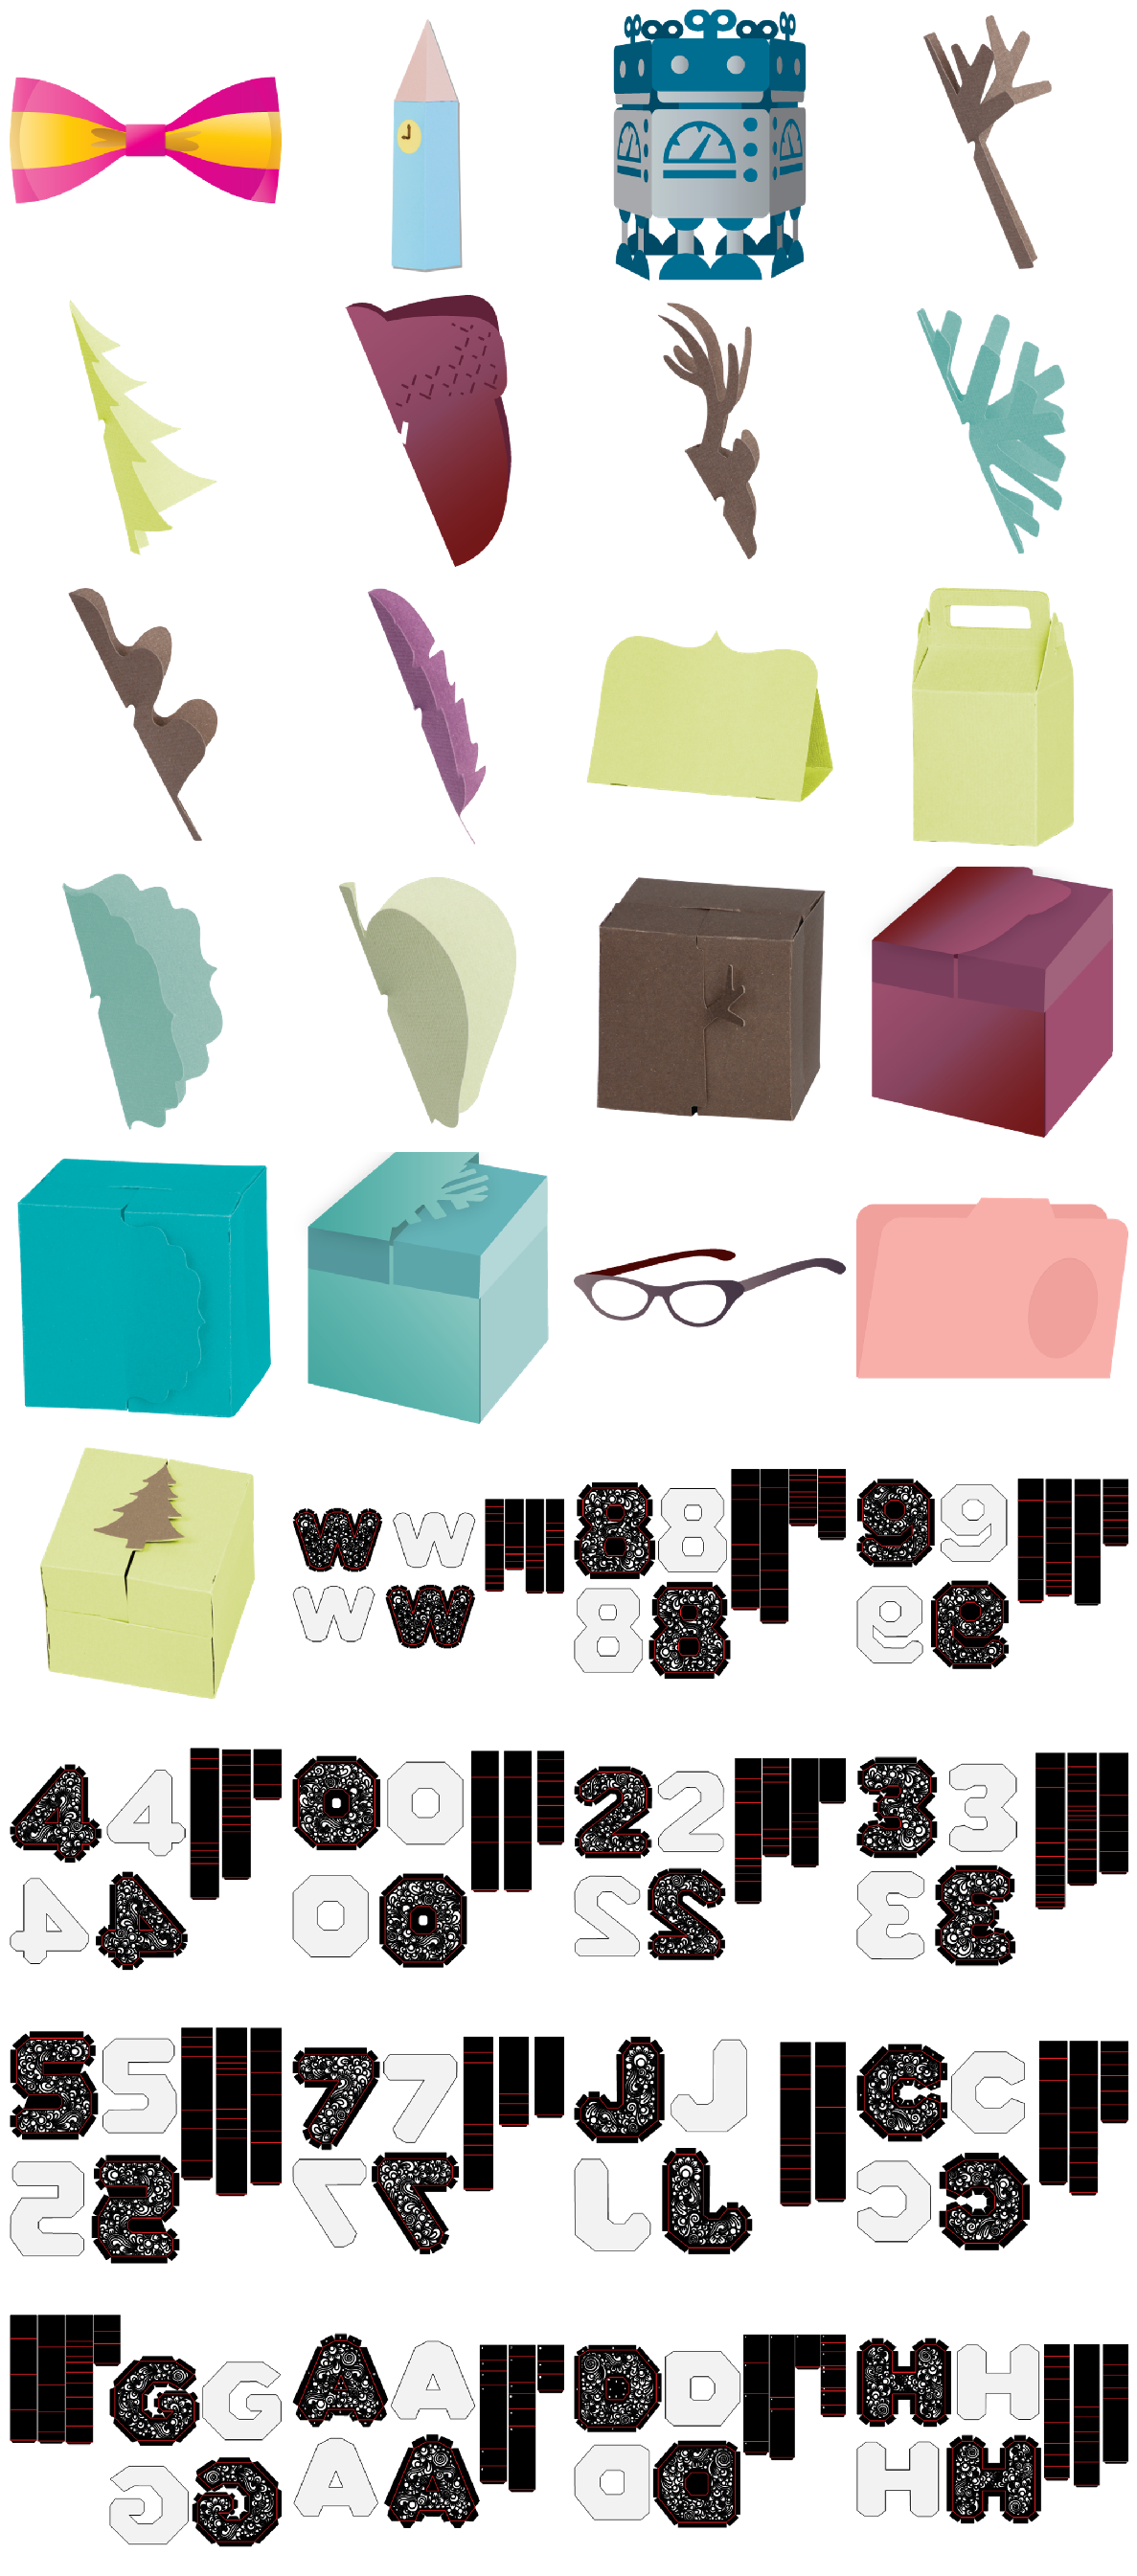

In [35]:
necessary_keywords = ['3D']  # Set your necessary keywords here
matching_items = process_items(data, necessary_keywords)
show_images_from_list(matching_items[0:36])

# Create "Single" image list

154512


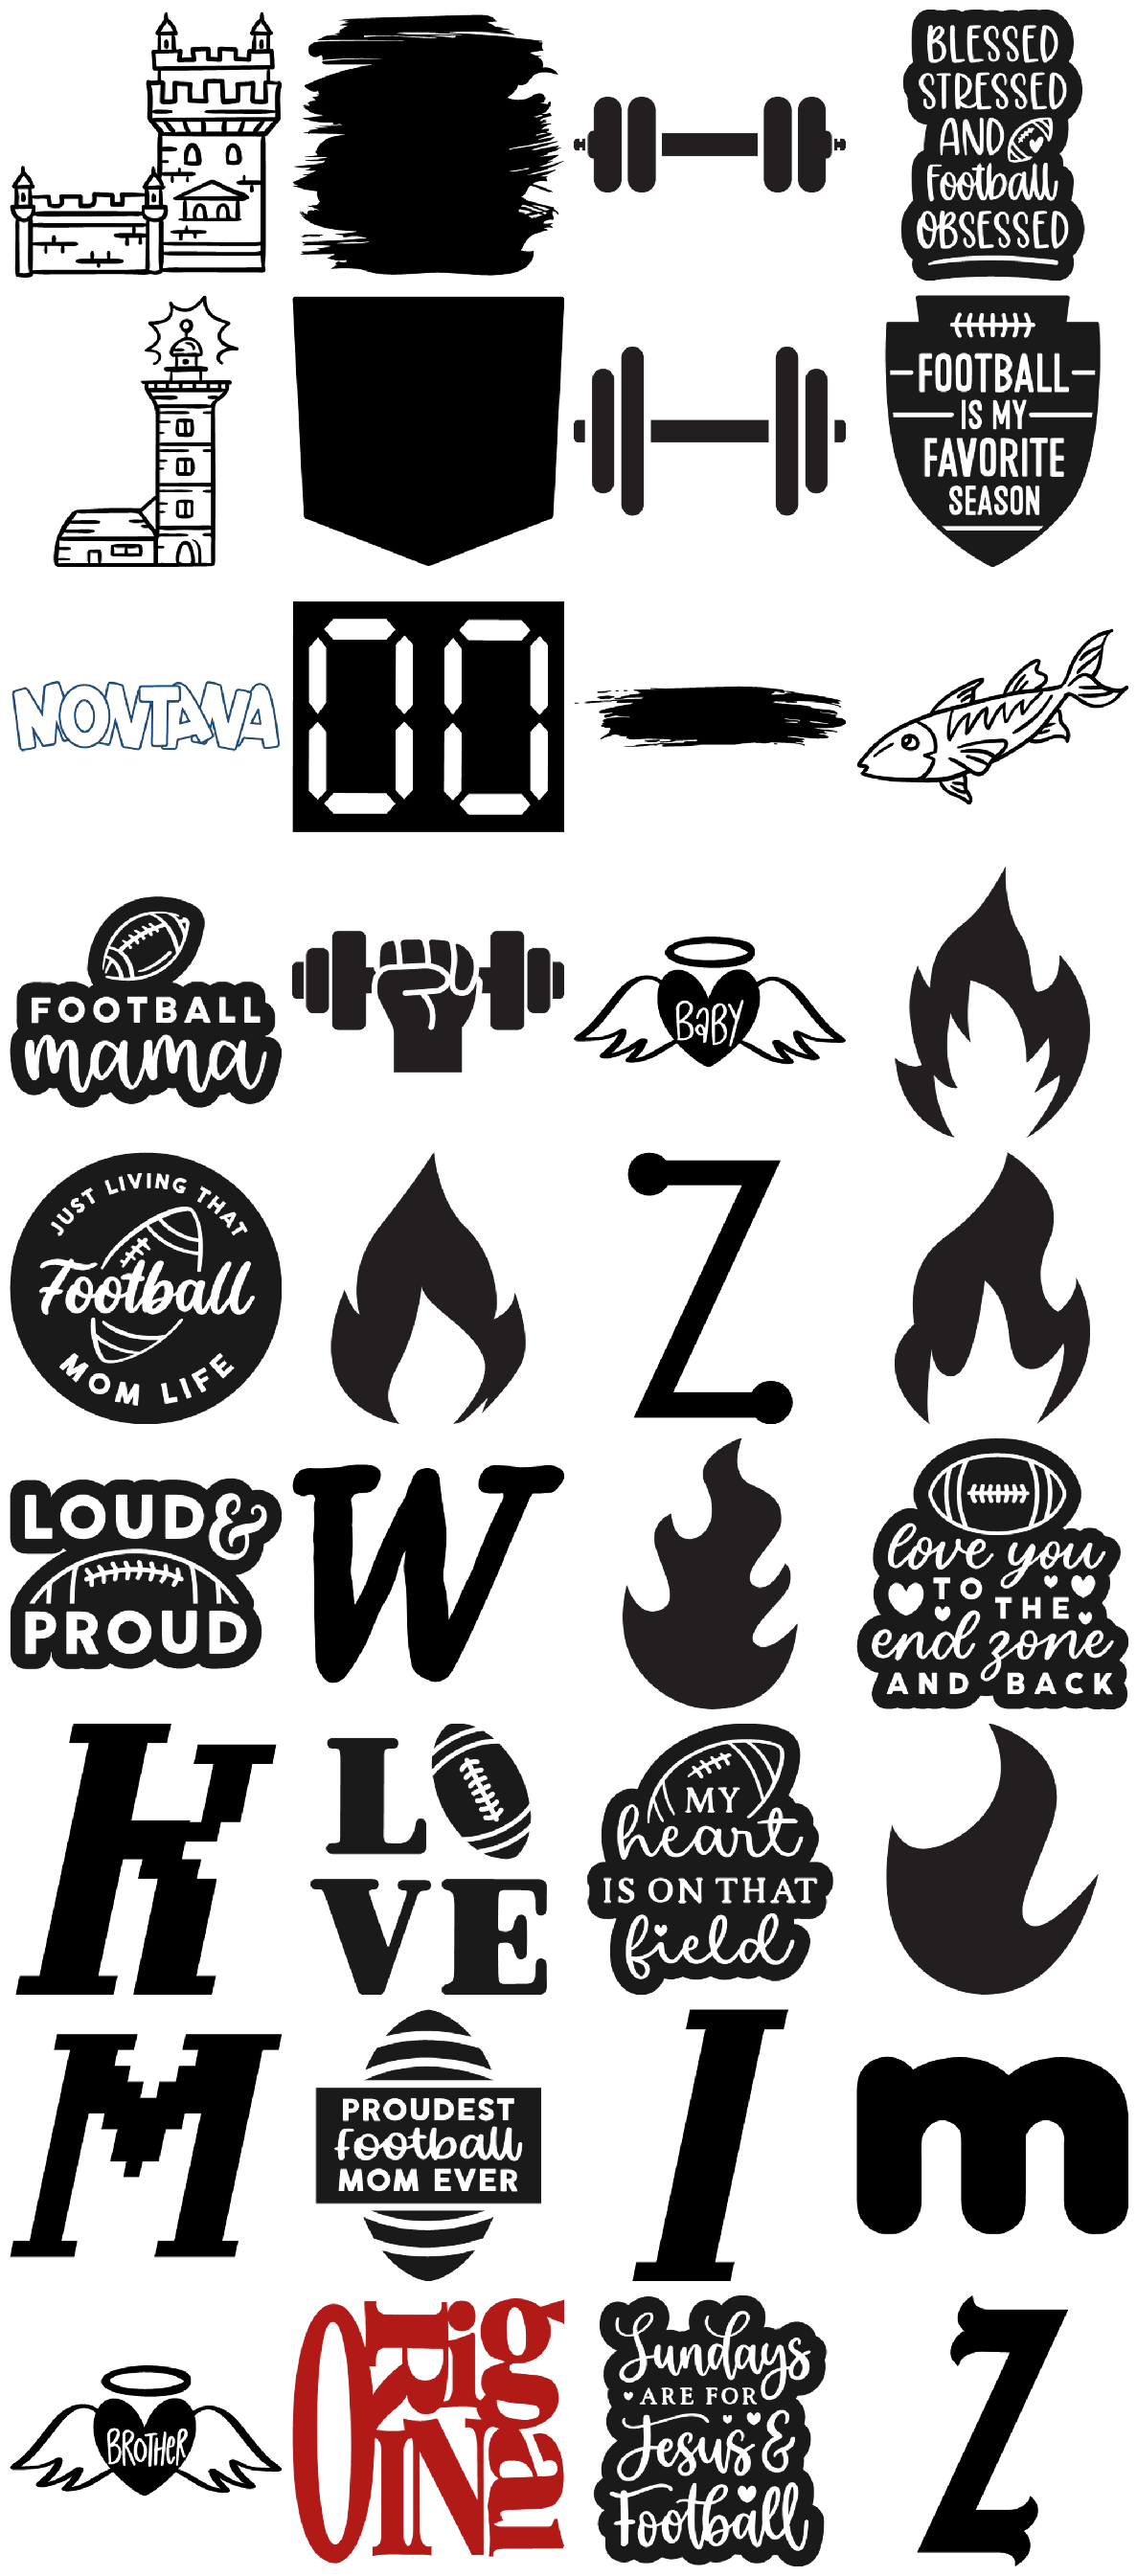

In [6]:
necessary_keywords = ['Single']  # Set your necessary keywords here
single_items = process_items(data, necessary_keywords)
print(len(single_items))
show_images_from_list(single_items[0:36])

# Create "Multi" image list

107850


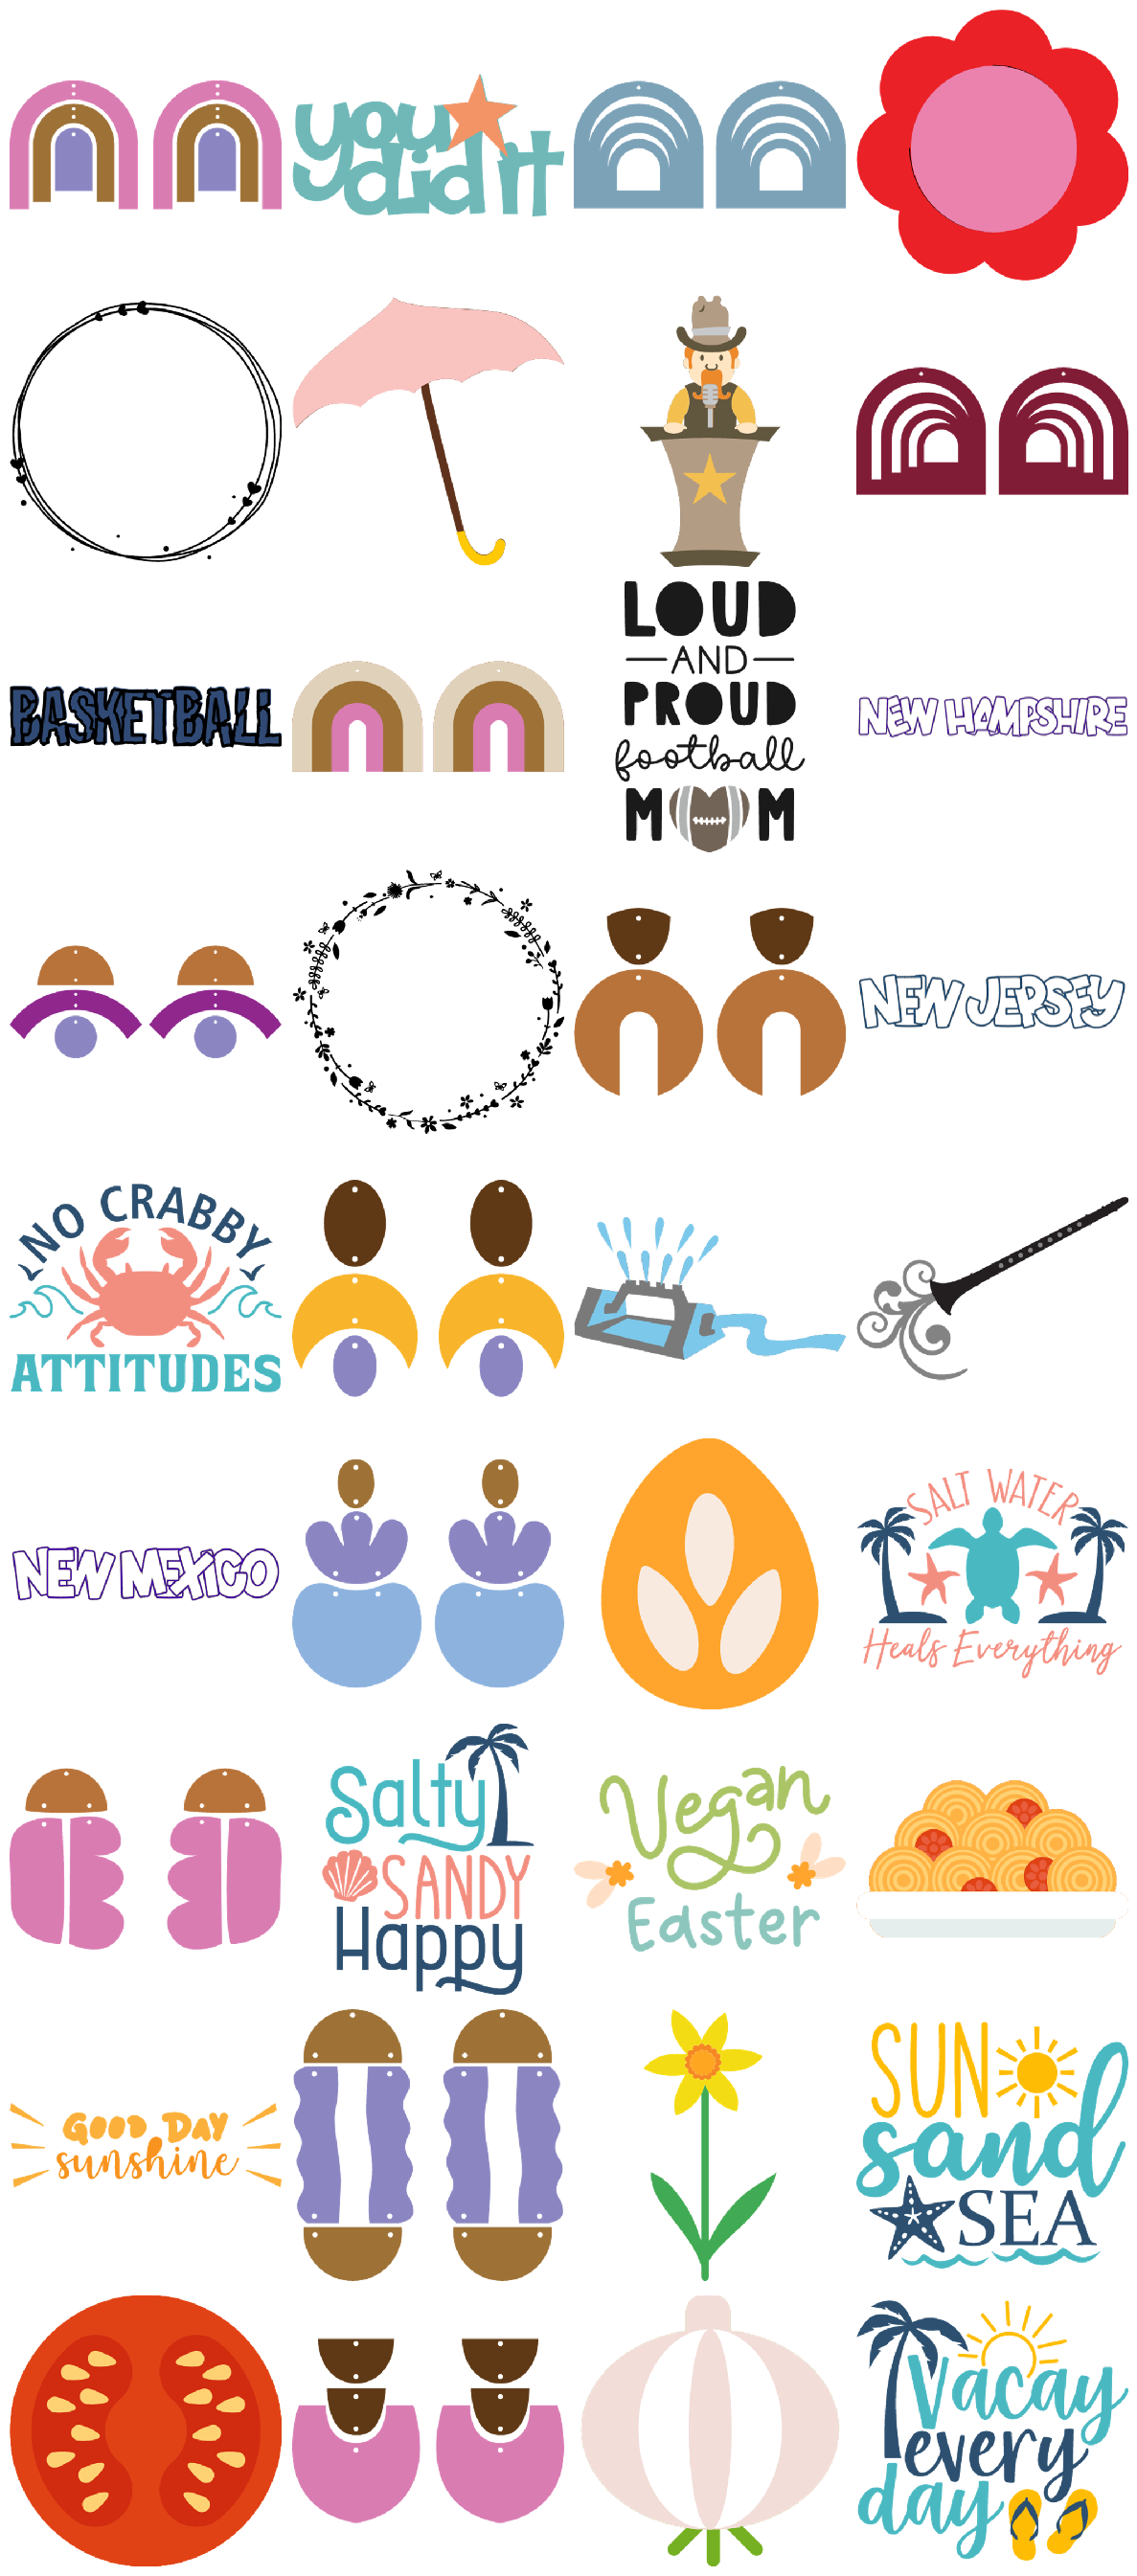

In [22]:
necessary_keywords = ['Multi', 'Cut Only']  # Set your necessary keywords here
multi_items = process_items(data, necessary_keywords)
print(len(multi_items))
show_images_from_list(multi_items[0:36])

# Create "Draw" image list

4805


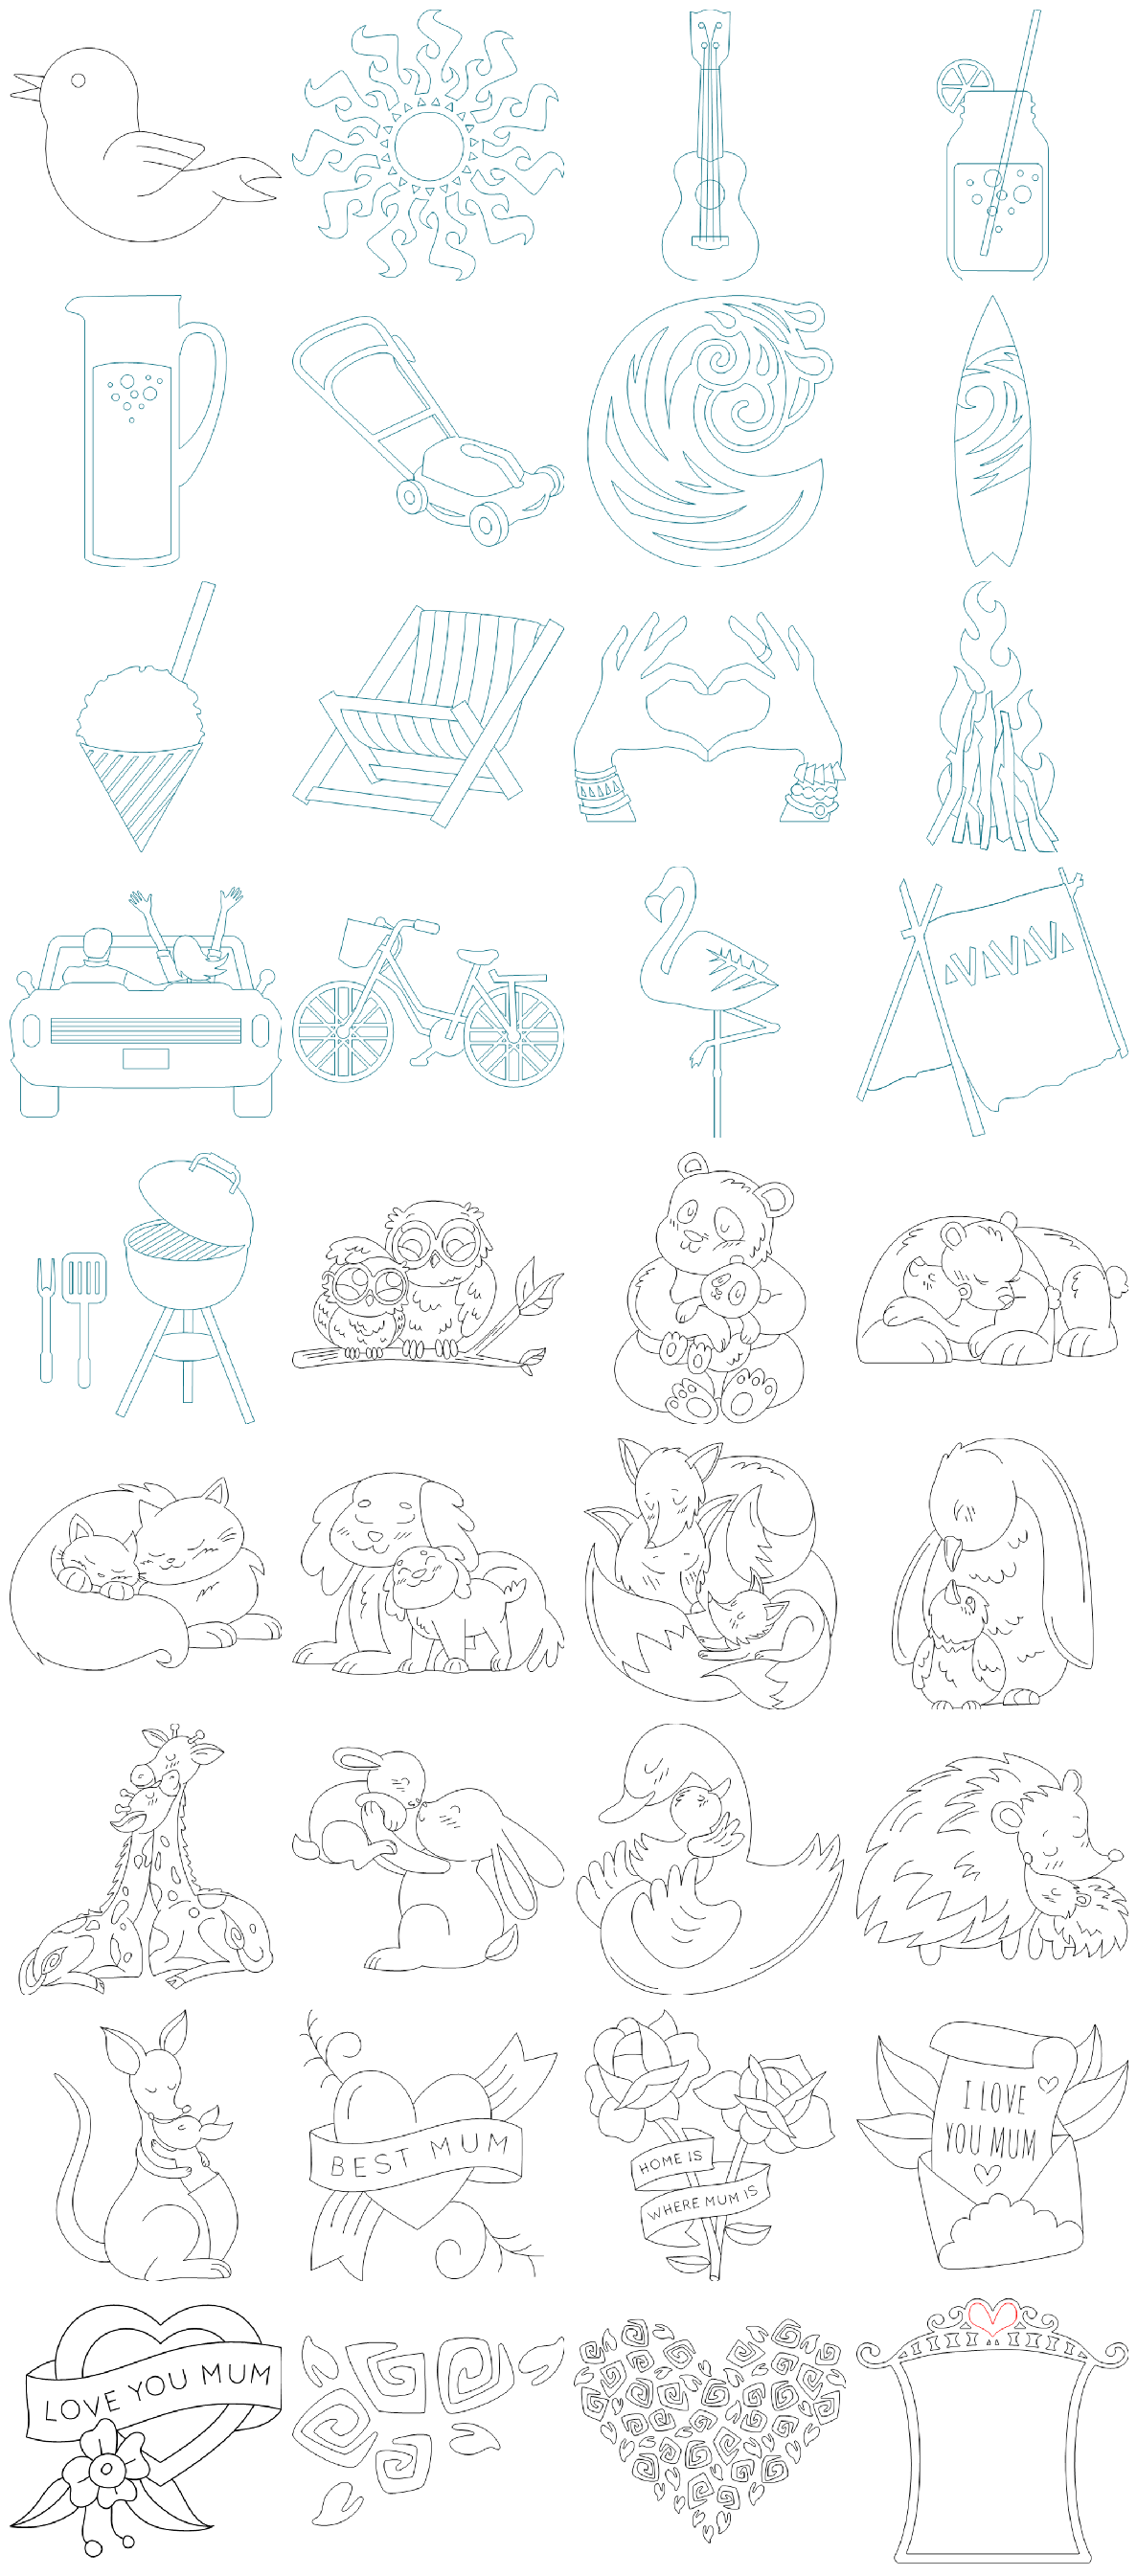

In [21]:
necessary_keywords = ['Draw Only']  # Set your necessary keywords here
draw_items = process_items(data, necessary_keywords)
print(len(draw_items))
show_images_from_list(draw_items[0:36])

# Create "Simple Image" list

112033


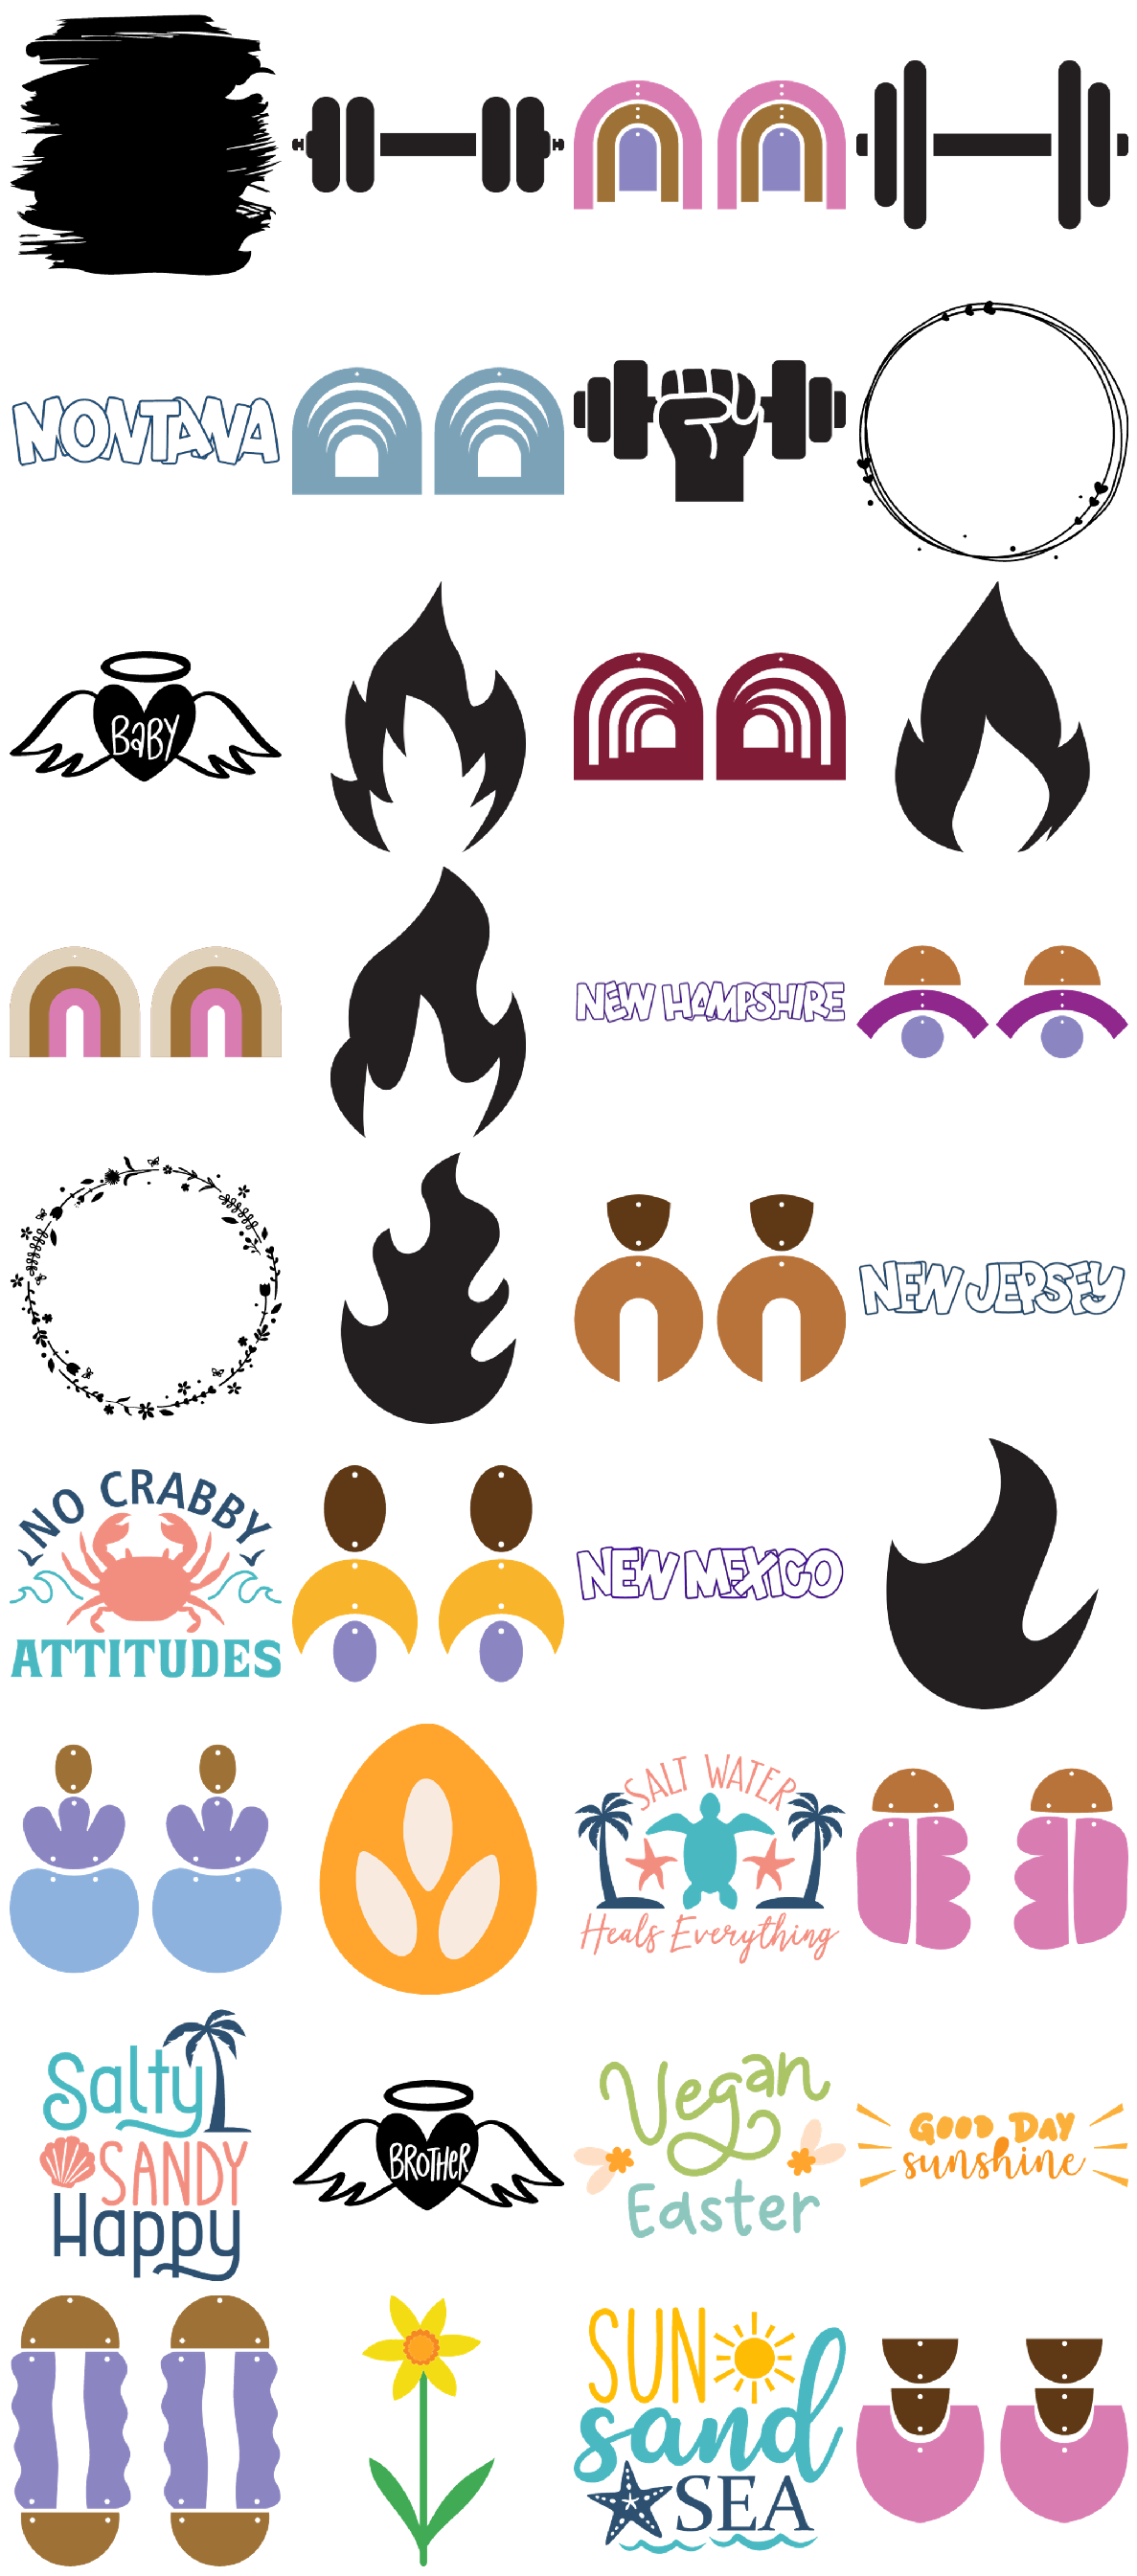

In [20]:
necessary_keywords = ['Simple Image']  # Set your necessary keywords here
simple_items = process_items(data, necessary_keywords)
print(len(simple_items))
show_images_from_list(simple_items[0:36])

# Create "Disney" image list

60


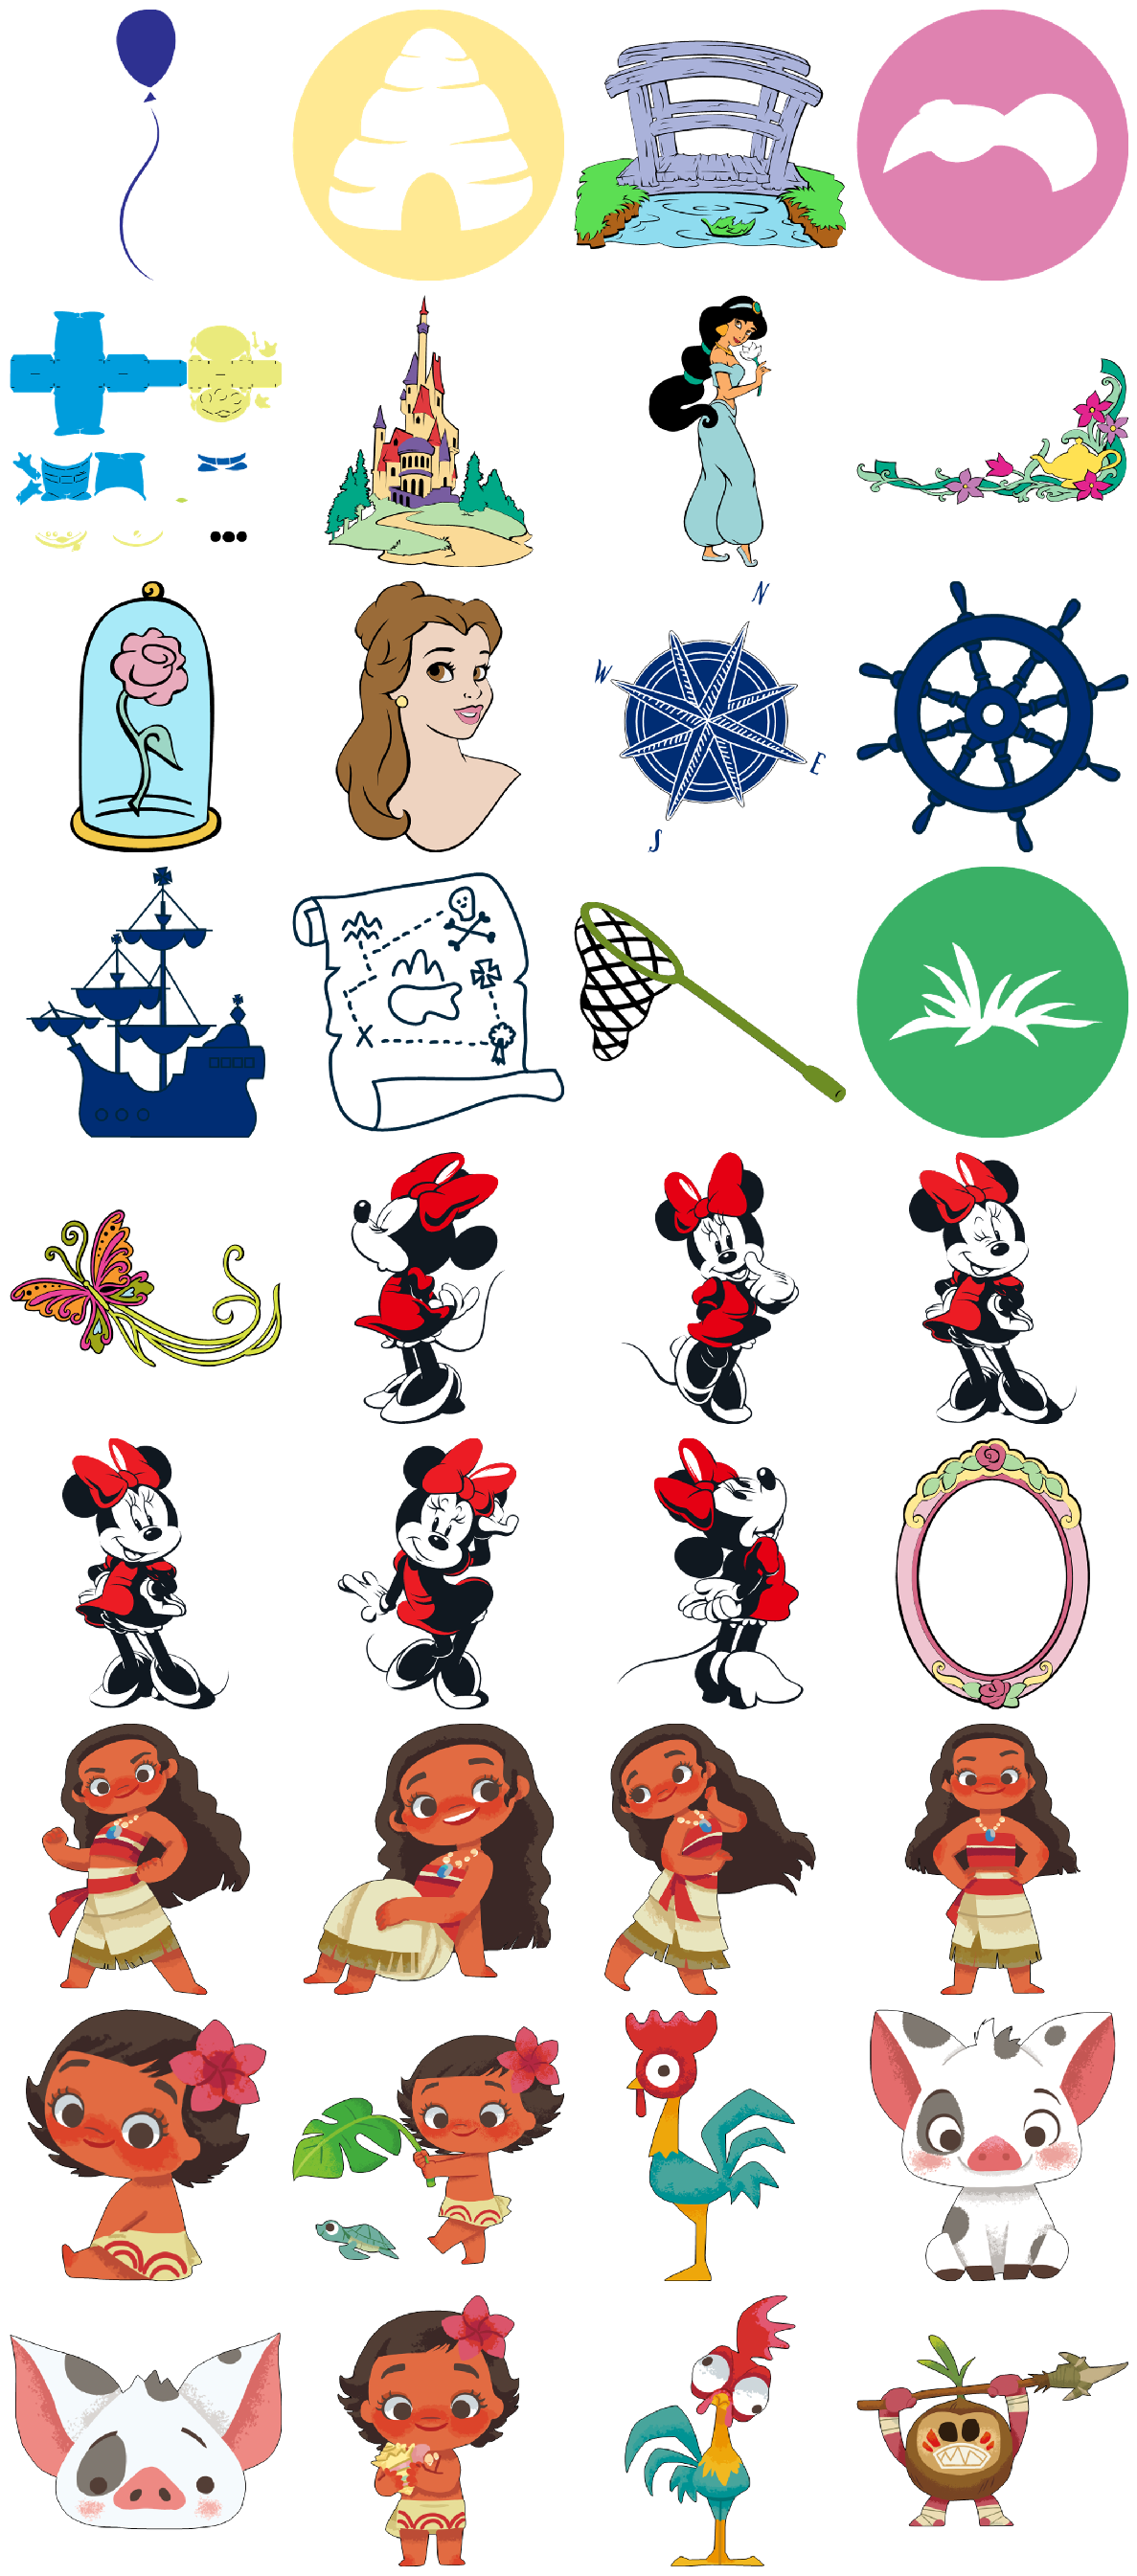

In [19]:
necessary_keywords = ['Disney']  # Set your necessary keywords here
disney_items = process_items(data, necessary_keywords)
print(len(disney_items))
show_images_from_list(disney_items[0:36])

# Create "Sticker Paper" image list

87


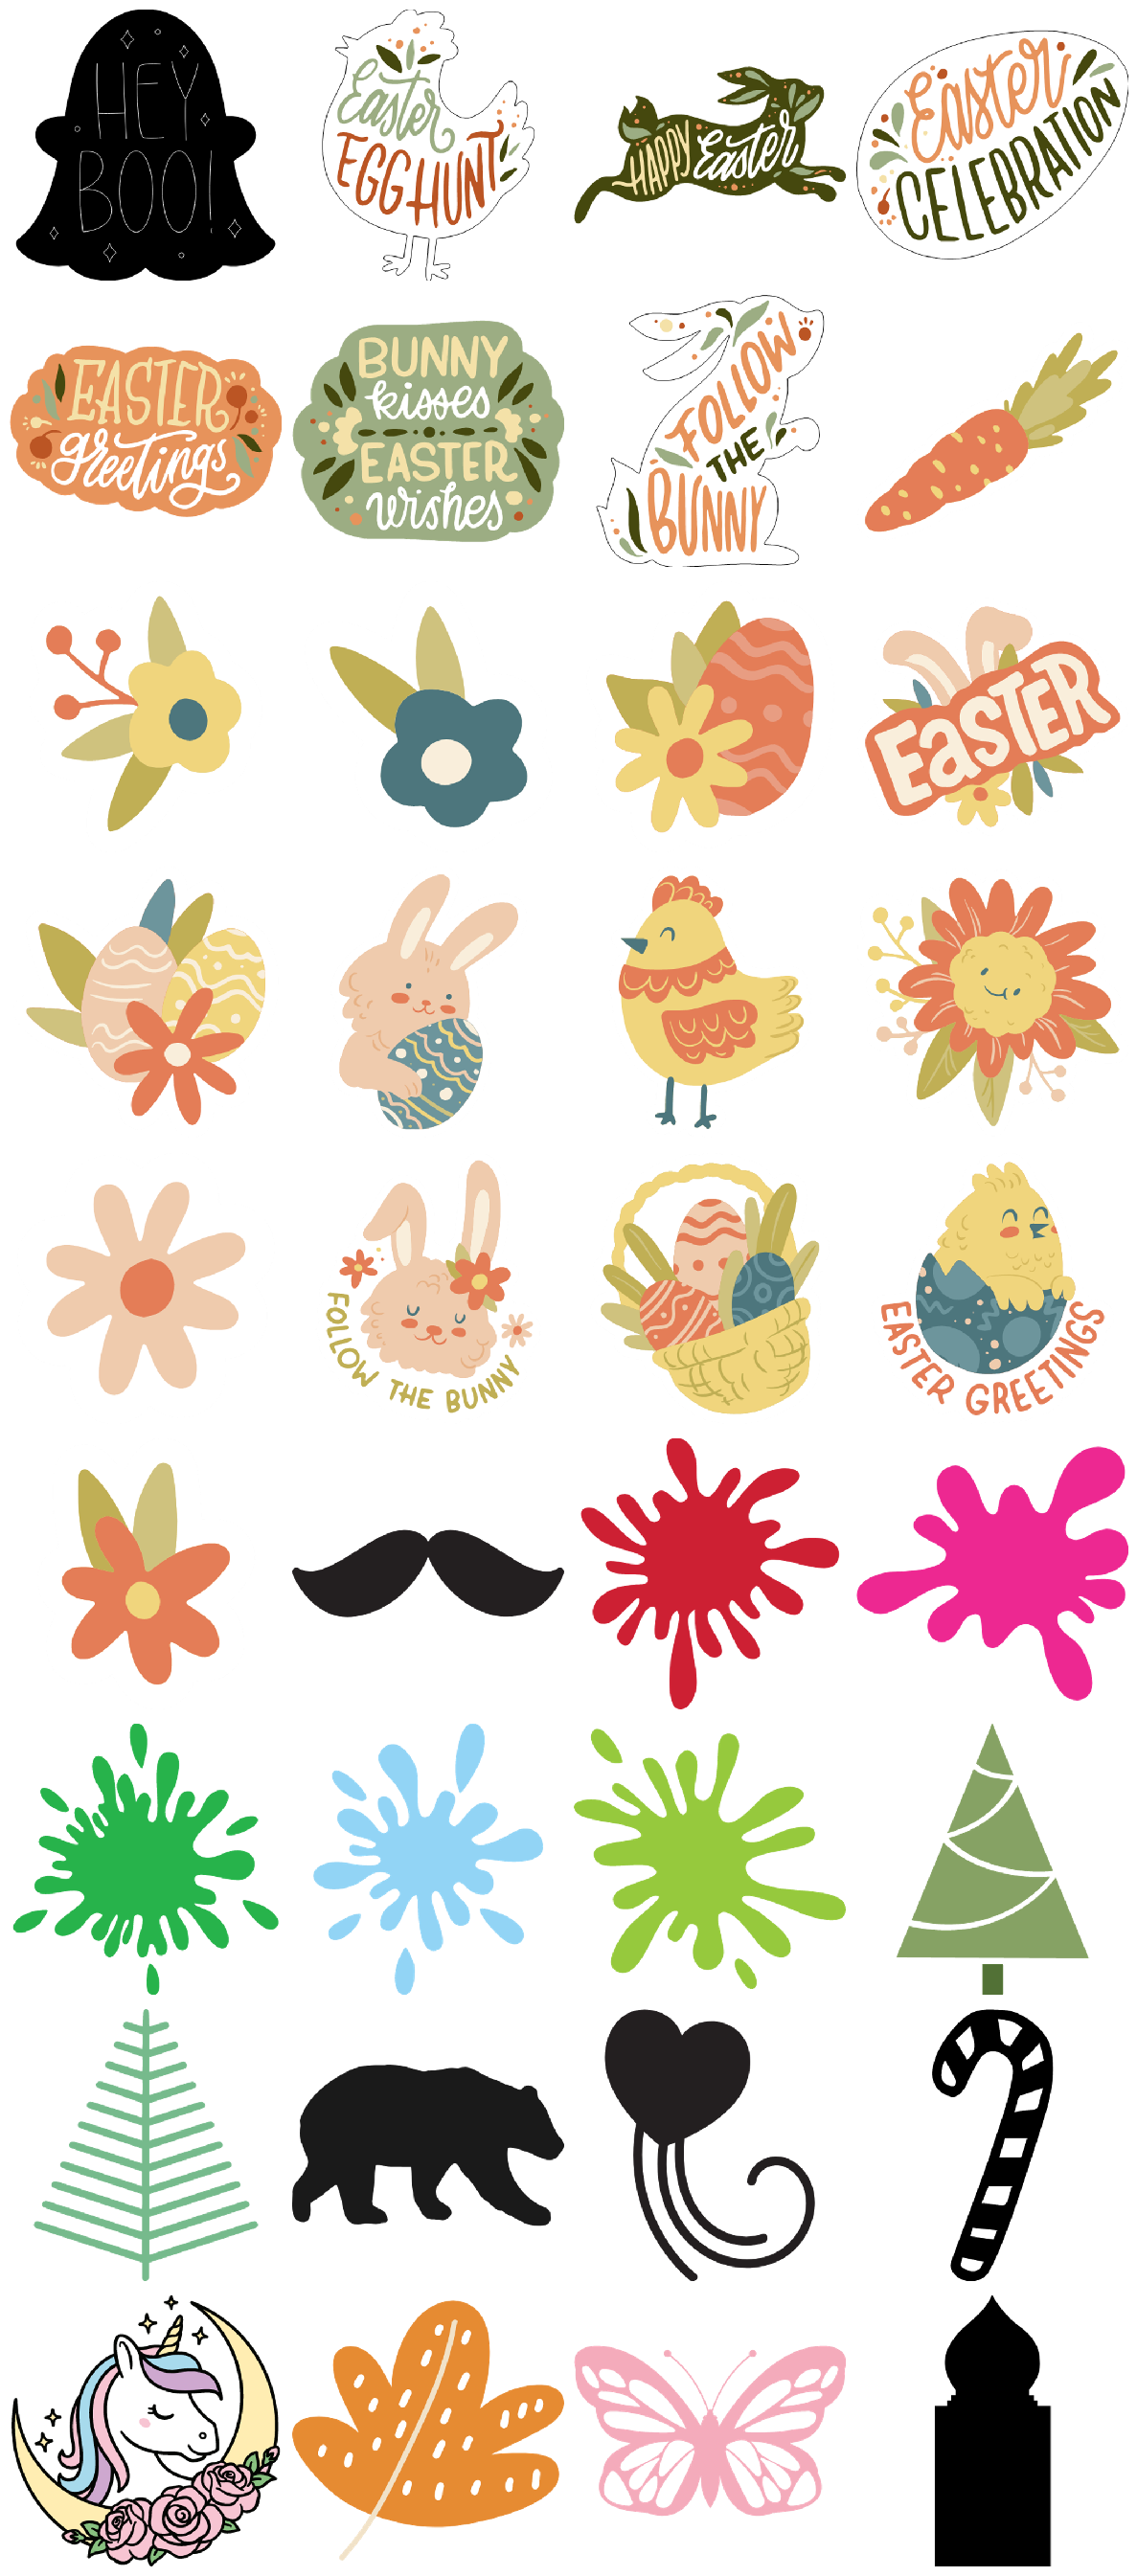

In [18]:
necessary_keywords = ['Sticker Paper']  # Set your necessary keywords here
sticker_items = process_items(data, necessary_keywords)
print(len(sticker_items))
show_images_from_list(sticker_items[0:36])

# Upload images for "Types" and "Styles" in S3 bucket

In [16]:
import os
import requests
import boto3
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

def convert_image(image):
    if image.mode == 'RGBA':
        # Create a new RGBA image with white background
        background = Image.new('RGBA', image.size, (255, 255, 255, 255))
        image = Image.alpha_composite(background, image)

        # Convert RGBA image to RGB
        image = image.convert('RGB')
    return image

def resize_image(image, size):
    # Resize the image to the desired size
    image = image.resize(size)
    return image

def upload_images_to_s3(items, bucket_name, subfolder, image_type, size):
    s3_client = boto3.client('s3')

    # Create the subfolder in the S3 bucket if it doesn't exist
    s3_client.put_object(Bucket=bucket_name, Key=f"{subfolder}/")

    def upload_image(item, index):
        url = item['previewUrl'][0]
        name = item['name'][0]

        # Download the image from the URL
        response = requests.get(url)
        image_content = response.content
        

        # Create a PIL image from the downloaded content
        image = Image.open(io.BytesIO(image_content))

        # Convert the image if it's in RGBA format
        image = convert_image(image)

        # Resize the image to the desired size
        image = resize_image(image, size)

        # Convert the image to bytes
        image_bytes = io.BytesIO()
        image.save(image_bytes, format='PNG')
        image_bytes.seek(0)

        # Generate unique number for the file name
        image_name = str(index)

        # Upload the image to S3
        image_key = f"{subfolder}/{image_name}.png"
        s3_client.put_object(Bucket=bucket_name, Key=image_key, Body=image_bytes)

        # Create the text file and upload it to S3
        text_content = image_type + ", " + name.lower()
        text_key = f"{subfolder}/{image_name}.txt"
        s3_client.put_object(Bucket=bucket_name, Key=text_key, Body=text_content)

    # Use ThreadPoolExecutor for parallel image uploading
    with ThreadPoolExecutor() as executor:
        executor.map(upload_image, items, range(len(items)))

In [15]:
import os
import requests
import boto3
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import io

url = "https://pyrope-a-imgservice.cricut.com/design-public-mirror1/images/334007419/hireslargecomposite.png"
response = requests.get(url)
image_content = response.content
image = Image.open(io.BytesIO(image_content))
image = convert_image(image)
image = resize_image(image, (512, 512))
image_bytes = io.BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)

s3_client = boto3.client('s3')

# Create the subfolder in the S3 bucket if it doesn't exist
s3_client.put_object(Bucket=bucket_name, Key=f"{subfolder}/")
    
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/single_image'
image_key = f"{subfolder}/test.png"
s3_client.put_object(Bucket=bucket_name, Key=image_key, Body=image_bytes)

{'ResponseMetadata': {'RequestId': 'ZAMF8GC9TDQNVSM3',
  'HostId': '1Ggp6w33+Z/tbyjdQchxsWbEr2rHLqkkiH/Uh5HAVJBGXPcVU4bveJqrVjCYs9MztF4f1tgZcx6bocCC835CrQ==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1Ggp6w33+Z/tbyjdQchxsWbEr2rHLqkkiH/Uh5HAVJBGXPcVU4bveJqrVjCYs9MztF4f1tgZcx6bocCC835CrQ==',
   'x-amz-request-id': 'ZAMF8GC9TDQNVSM3',
   'date': 'Fri, 21 Jul 2023 00:12:16 GMT',
   'x-amz-version-id': '_8LNr4KIRvAujPT_OLASagUYlkmfX91Q',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"57fc31614b9afac1c7b9ba3351a501cf"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"57fc31614b9afac1c7b9ba3351a501cf"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '_8LNr4KIRvAujPT_OLASagUYlkmfX91Q'}

## Simple Image

In [27]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/simple_image'
image_type = "simple image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(simple_items))
upload_images_to_s3(simple_items, bucket_name, subfolder, image_type, size)

112033


# Disney

In [23]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/disney_image'
image_type = "disney image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(disney_items))
upload_images_to_s3(disney_items, bucket_name, subfolder, image_type, size)

60


# Sticker

In [24]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/sticker_image'
image_type = "sticker image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(sticker_items))
upload_images_to_s3(sticker_items, bucket_name, subfolder, image_type, size)

87


# Draw

In [26]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/draw_image'
image_type = "draw image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(draw_items))
upload_images_to_s3(draw_items, bucket_name, subfolder, image_type, size)

4805


# Single

In [25]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/single_image'
image_type = "single image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(single_items))
upload_images_to_s3(single_items, bucket_name, subfolder, image_type, size)

154512


# Multiple

In [28]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/multi_image'
image_type = "multi image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(multi_items))
upload_images_to_s3(multi_items, bucket_name, subfolder, image_type, size)

107850


# Silhouette

In [16]:
import os
import requests
import boto3
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu

def convert_image(image):
    if image.mode == 'RGBA':
        # Create a new RGBA image with white background
        background = Image.new('RGBA', image.size, (255, 255, 255, 255))
        image = Image.alpha_composite(background, image)

        # Convert RGBA image to RGB
        image = image.convert('RGB')
    return image

def resize_image(image, size):
    # Resize the image to the desired size
    image = image.resize(size)
    return image

def convert_image_to_bw(image_gray):   
    # Convert image to numpy array
    image_array = np.array(image_gray)
    
    # Calculate optimal threshold using Otsu's method
    threshold = threshold_otsu(image_array)
    
    # Apply binary threshold
    image_bw = image_gray.point(lambda x: 0 if x < threshold else 255, mode='L')
    
    return image_bw


def upload_images_bw_to_s3(items, bucket_name, subfolder, image_type, size):
    s3_client = boto3.client('s3')

    # Create the subfolder in the S3 bucket if it doesn't exist
    s3_client.put_object(Bucket=bucket_name, Key=f"{subfolder}/")

    def upload_image(item, index):
        url = item['previewUrl'][0]
        name = item['name'][0]

        # Download the image from the URL
        response = requests.get(url)
        image_content = response.content
        

        # Create a PIL image from the downloaded content
        image = Image.open(io.BytesIO(image_content))
        
        # Convert the image if it's in RGBA format
        image = convert_image(image)

        # Resize the image to the desired size
        image = resize_image(image, size)
        
        image = image.convert('L') 
        
        # Convert the black and white image to binary format
        image_binary = convert_image_to_bw(image)
        
        # Convert the image to bytes
        image_bytes = io.BytesIO()
        image_binary.save(image_bytes, format='PNG')
        image_bytes.seek(0)

        # Generate unique number for the file name
        image_name = str(index)     

        # Upload the image to S3
        image_key = f"{subfolder}/{image_name}.png"
        s3_client.put_object(Bucket=bucket_name, Key=image_key, Body=image_bytes)

        # Create the text file content with the name and image type
        text_content = image_type + ", " + name.lower()

        # Upload the text file to S3
        text_key = f"{subfolder}/{image_name}.txt"
        s3_client.put_object(Bucket=bucket_name, Key=text_key, Body=text_content)

        # Delete the locally saved image
        # os.remove(image_path)

        # print(f"Uploaded {image_name}.{image_type} and {image_name}.txt to S3")

    # Use ThreadPoolExecutor for parallel image uploading
    with ThreadPoolExecutor() as executor:
        executor.map(upload_image, items, range(len(items)))

In [17]:
# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/silhouette_image'
image_type = "silhouette image"
size = (512, 512)

# Call the upload_images_to_s3 function
print(len(single_items))
upload_images_bw_to_s3(single_items,  bucket_name, subfolder, image_type, size)

154512


In [15]:
import os
import requests
import boto3
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu
import io

def convert_image(image):
    if image.mode == 'RGBA':
        # Create a new RGBA image with white background
        background = Image.new('RGBA', image.size, (255, 255, 255, 255))
        image = Image.alpha_composite(background, image)

        # Convert RGBA image to RGB
        image = image.convert('RGB')
    return image

def resize_image(image, size):
    # Resize the image to the desired size
    image = image.resize(size)
    return image

def convert_image_to_bw(image_gray):   
    # Convert image to numpy array
    image_array = np.array(image_gray)
    
    # Calculate optimal threshold using Otsu's method
    threshold = threshold_otsu(image_array)
    
    # Apply binary threshold
    image_bw = image_gray.point(lambda x: 0 if x < threshold else 255, mode='L')
    
    return image_bw

url = single_items[34]['previewUrl'][0]
print(url)

# Download the image from the URL
response = requests.get(url)
image_content = response.content


# Create a PIL image from the downloaded content
image = Image.open(io.BytesIO(image_content))

# Convert the image if it's in RGBA format
image = convert_image(image)

# Resize the image to the desired size
size = (512, 512)
image = resize_image(image, size)

image = image.convert('L') 

# Convert the black and white image to binary format
image_binary = convert_image_to_bw(image)

# Generate a unique number for the file name
image_name = "0"

# Save the image locally
image_path = f"{image_name}.png"
image_binary.save(image_path)

# Convert the image to bytes
image_bytes = io.BytesIO()
image_binary.save(image_bytes, format='PNG')
image_bytes.seek(0) 

# Specify the S3 bucket name and subfolder
bucket_name = 'sagemaker-image-generation-data'
subfolder = 'lora_datasets/train_data_from_cricut/silhouette_image'
image_type = "silhouette image"

s3_client = boto3.client('s3')

# Upload the image to S3
image_key = f"{subfolder}/{image_name}.png"
s3_client.put_object(Bucket=bucket_name, Key=image_key, Body=image_bytes)

https://pyrope-a-imgservice.cricut.com/design-public-mirror1/images/868924494/hireslargecomposite.png


{'ResponseMetadata': {'RequestId': 'TYBDCV10NEZQFRPK',
  'HostId': 'dtfPmgktRX6+8egdm3U2SwTtoqRbNAlGFe3QpUXILvTPixfSDfcK+RVhsVBgCn83RHKdgkWO1VU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dtfPmgktRX6+8egdm3U2SwTtoqRbNAlGFe3QpUXILvTPixfSDfcK+RVhsVBgCn83RHKdgkWO1VU=',
   'x-amz-request-id': 'TYBDCV10NEZQFRPK',
   'date': 'Fri, 21 Jul 2023 10:04:18 GMT',
   'x-amz-version-id': 'ctUyCAZQ5GC0OCLZBdH5SYnS_hTKm8c0',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"f9d8cfb808ec5c69aaba53ffeeaeca77"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"f9d8cfb808ec5c69aaba53ffeeaeca77"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'ctUyCAZQ5GC0OCLZBdH5SYnS_hTKm8c0'}

In [57]:
url = single_items[34]['previewUrl'][0]
print(url)

https://pyrope-a-imgservice.cricut.com/design-public-mirror1/images/868924494/hireslargecomposite.png
